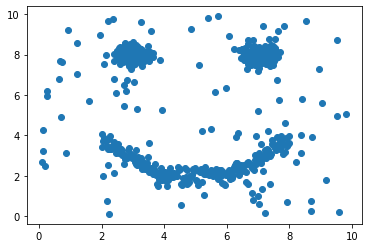

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def combine( x, y, x1, y1):
    return np.concatenate( (x,x1) ), np.concatenate( (y,y1) )

def gaussian_blob(center, N, width, height):
    return np.random.normal( center[0], width, N), np.random.normal( center[1], height, N)

def uniform_background(lower_left, upper_right, N):
    return np.random.uniform( lower_left[0], upper_right[0], size=N), np.random.uniform( lower_left[1], upper_right[1], size=N)

def noisy_parabola( xlimits, y, N, eps, a=1):
    c = (xlimits[1] + xlimits[0])/2
    x = np.linspace( *xlimits, N) 
    return x, a*(x-c)**2 + y + np.random.normal(0,eps,N)


np.random.seed(12345678)
x, y = uniform_background( (0,0), (10,10), 100 )
x, y = combine( x, y, *gaussian_blob( (3,8),200, 0.25,0.25) )
x, y = combine( x, y, *gaussian_blob( (7,8),200, 0.25,0.25) )
x, y = combine( x, y, *noisy_parabola( (2,8), 2, 200, 0.25, 0.2))

plt.scatter( x, y )
plt.show()


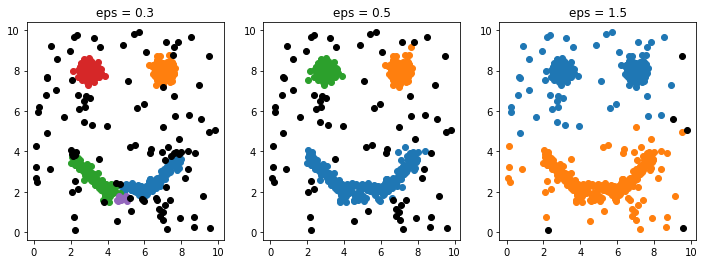

In [99]:
from sklearn.cluster import DBSCAN
X = np.stack((x, y), axis=-1)


colors = { i:'C'+str(i) for i in range(10) } 
colors[-1] = 'k'

eps_labels = {}
def fit_for_eps(eps, ax):
    db = DBSCAN(eps=eps, min_samples=10).fit(X)
    eps_labels[eps] =  db.labels_
    for k, col in colors.items():
        xy = X[ db.labels_ == k ]  
        ax.scatter(xy[:, 0],xy[:, 1],c=col)

fig, ax = plt.subplots(1,3, figsize=(12,4))

for i,eps in enumerate([0.3,0.5,1.5]):
    fit_for_eps(eps, ax[i]); 
    ax[i].set_title( "eps = {}".format(eps) )

plt.show()
    

So clearly the value of eps has an effect on the number of clusters. What if 
 - we don't know the ground truth?
 - we have more than 2 or 3 dimensional data?
 - we have to cluster 1000s of different datasets?<br>
 
We need some internal consistency metrics to check what the best fit is. 

#### Silhouette
Let $a(i)$ be the mean distance between data point $i$ and all the other elements in its cluster. Let $b(i)$ be the *smallest* mean distance between $i$ and any other cluster. The silhouette of a data point is
$$
s(i) = \frac{b(i) - a(i)}{max[ a(i), b(i) ] }
$$
The silhouette will be close to 1 if the point $i$ is much closer to its own cluster than any others. It will be close to -1 if it is closer to another cluster. The average silhouette
$$
S_k = \frac{1}{N} \sum_i s(i)
$$
Is sometimes used as an overall index of clustering quality with $k$ clusters.

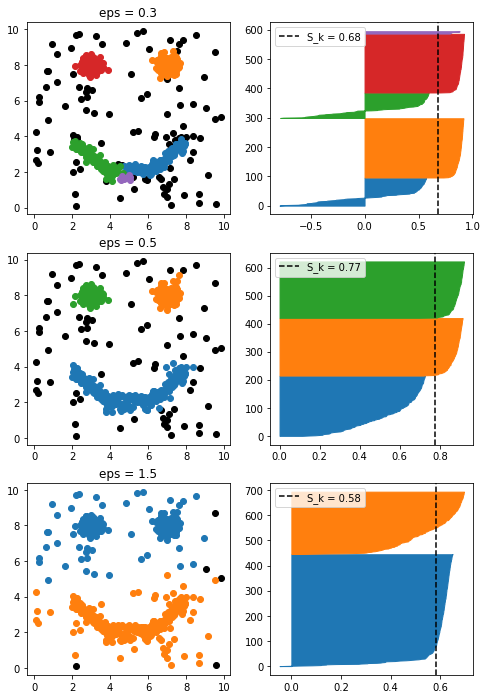

In [134]:
from sklearn.metrics import silhouette_samples, silhouette_score

eps_silhouettes = {}
eps_avsilhouettes = {}

for eps, cluster_labels in eps_labels.items():
    
    ClusteredX = X[ cluster_labels != -1 ]  
    labels = cluster_labels[ cluster_labels != -1 ]  
    
    eps_avsilhouettes[eps] = silhouette_score(ClusteredX, labels)
    eps_silhouettes[eps] = silhouette_samples(ClusteredX, labels)


fig, ax = plt.subplots(3,2, figsize=(8,12))
for i,(eps,cluster_labels) in enumerate(eps_labels.items()):
    nc = len(set(cluster_labels))
    y_lower = 0
    for k in range(-1,nc-1):
        col = colors[k]
        xy = X[ cluster_labels == k ]  
        ax[i,0].scatter(xy[:, 0],xy[:, 1],c=col)
        ax[i,0].set_title( "eps = {}".format(eps) )
        
        if k == -1: continue
        labels = cluster_labels[ cluster_labels != -1 ]  
            
        silhouette_values = eps_silhouettes[eps][labels == k]
        silhouette_values.sort()
        size = silhouette_values.shape[0]
        y_upper = y_lower + size

        ax[i,1].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            silhouette_values,
            facecolor=col,
            edgecolor=col,
            alpha=1,
        )

        y_lower = y_upper
    ax[i,1].axvline(x=eps_avsilhouettes[eps], color="k", linestyle="--", label="S_k = {:.2f}".format(eps_avsilhouettes[eps]) )
    ax[i,1].legend()  

plt.show()


I don't know if these plots have a name. They look like a set of cooking knives. The top one is definitely wrong, the green and blue clusters have many very badly clustered points. The middle one looks good, except the blue cluster points all have below average silhouette. This is (I think) a feature of many of these metrics - they prefer convex clusters, the blue one is not convex. The bottom one also looks good by this metric but has the lowest average silhouette. 

#### Davies-Bouldin Index

Let $d(i)$ be the average distance between each data point in a cluster from the centroid (the cluster diameter). Let $m(i,j)$ be the distance between cluster centroids $i$ and $j$. Let
$$
R(i,j) = \frac{s(i) + s(j)}{m(i,j)}
$$
and
$$
DB = \frac{1}{k} \sum_j max_{i \neq j}[ R(i,j) ]
$$

The idea is that if two clusters are well separated from each other then $R(i,j)$ is small. The DB index finds the worst case for each cluster, sums them all up and averages.

#### Calinski-Harabasz Index

Let $c_k$ be the center of cluster $k$ and $c$ be the center of the data. The covariance matrix of points in $k$ is
$$
w_k = (x - c_k)(x - c_k)^T
$$
and of clusters is
$$
b_k = (c_k - c)(c_k - c)^T
$$
The within group dispersion is $W = Tr[ \sum_k w_k ]$ and between group dispersion is $B = Tr[ \sum_k b_k ]$. The CH-index is
$$
CH = \frac{B}{W}\frac{N - n_c}{n_c - 1}
$$

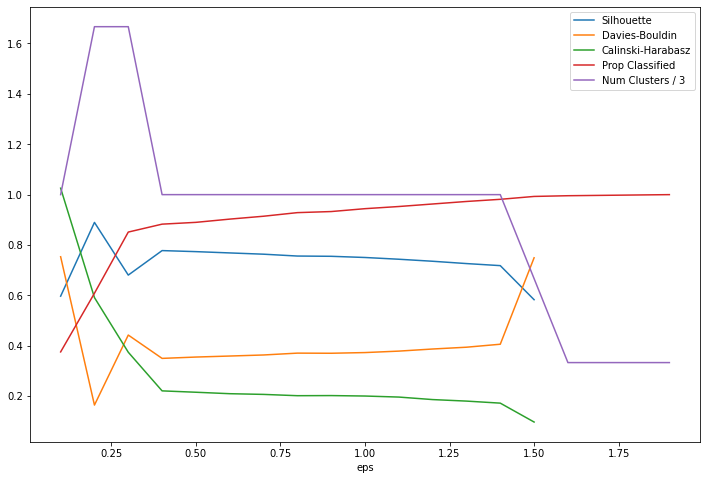

In [163]:
from sklearn import metrics

def labels_for_eps(eps, X):
    db = DBSCAN(eps=eps, min_samples=10).fit(X)
    return db.labels_


scores = {
    "Silhouette":[],
    "Davies-Bouldin":[],
    "Calinski-Harabasz":[],
    "Prop Classified":[],
    "Num Clusters / 3":[],
}
for i,eps in enumerate(np.arange(0.1,2,0.1)):
    labels = labels_for_eps(eps, X); 
    
    Xclustered = X[ labels != -1 ]
    assigned_labels = labels[ labels != -1 ] 

    nc = len(set(assigned_labels))
    if nc == 1: 
        sil = None
        ch = None
        db = None
    else:
        sil = metrics.silhouette_score(Xclustered, assigned_labels)
        ch = metrics.calinski_harabasz_score(Xclustered, assigned_labels) /10000
        db = metrics.davies_bouldin_score(Xclustered, assigned_labels)

    scores["Silhouette"].append(  sil )
    scores["Calinski-Harabasz"].append( ch )
    scores["Davies-Bouldin"].append( db )

    scores["Prop Classified"].append(  len(assigned_labels)/len(labels) )
    scores["Num Clusters / 3"].append(  nc/3 )

plt.figure( figsize=(12,8) )    
for tag, data in scores.items():    
    plt.plot(np.arange(0.1,2,0.1), data, label=tag)

plt.xlabel("eps")
plt.legend()
plt.show()


There's a lot going on here... 
 - The silhouette score is (just barely) maximised around 0.2
 - The DB index is minimised around 0.2
 - CH index keeps decreasing as a function of eps. Probably an artefact of the changing number of points that are actuall classified.
 - The proportion classified is quite low at 0.2
 - The detected number of clusters is 3 for a wide range of eps values between around 0.5 and 1.5
 
The CH index isn't useful here, but a naive maximisation approach for silhouette and DB would have eps=0.2 as the best.

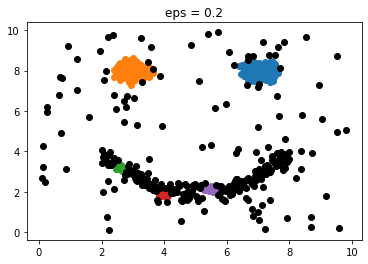

In [158]:
fig, ax = plt.subplots()
fit_for_eps(0.2, ax); 
ax.set_title( "eps = {}".format(0.2) )

plt.show()

Basically, by not classifying many of the points it's possible to find better clusters, but this is a prime way to split big clusters on the basis of local density fluctuations. Better to apply some threshold on the proportion of data points which have been assigned.

#### Bootstrap

Ok, so how about we
 - Make a composite index which accounts for clustering score and proportion clustered?
 - Do some sort of resampling to make sure we're measuring real differences
 
A very dumb composite index is 
$$F_\beta = (1+\beta^2)\frac{ps'}{p + \beta^2 s'}$$, 
where $s' = (1+s)/2$ is the rescaled silhouette score, here 0 is bad and 1 is good. $p$ is the proportion fit and $F_\beta$ is the harmonic mean of both of these where the score is $\beta$-times as important as the proportion fit.

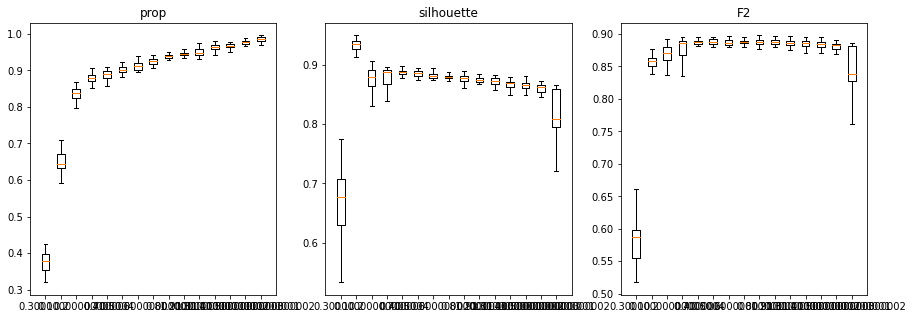

In [197]:
N = len(X)
Nboots = 40

data = {
"prop":[],
"silhouette":[],
"F2":[],
}
x = np.arange(0.1,1.6,0.1)
for i,eps in enumerate( x ) :
    
    props = np.empty(Nboots)
    scores = np.empty(Nboots)
    for n in range(Nboots):
        bX = X[ np.random.randint(N, size=N) ]
        labels = labels_for_eps(eps, bX); 

        assigned_labels = labels[ labels != -1 ] 
        Xclustered = bX[ labels != -1 ]
        
        if len(set(assigned_labels)) == 1: continue
            
        scores[n] = (metrics.silhouette_score(Xclustered, assigned_labels) + 1)/2
        props[n] = len(assigned_labels)/len(labels) 

    data["silhouette"].append( scores )
    data["prop"].append( props )
    data["F2"].append( 5*scores*props/(scores + 4*props) )

fig, ax = plt.subplots(1,3,figsize=(15, 5))
for i, (tag, d) in enumerate(data.items()):
    ax[i].boxplot( d, positions=x, widths=0.05 ,sym='')
    ax[i].set_xlim([x[0]-0.1,x[-1]+0.1])
    ax[i].set_title(tag)
plt.show()        

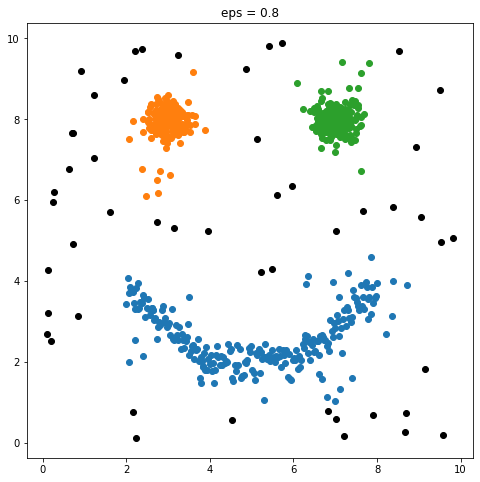

In [204]:
best_eps = x[ np.argmax( [ np.median(d) for d in data["F2"] ] ) ]
fig, ax = plt.subplots(1,1,figsize=(8,8))
fit_for_eps(best_eps, ax); 
ax.set_title( "eps = {}".format(best_eps) )
plt.show()